In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, f1_score, classification_report

In [82]:
df = pd.read_csv('../Data/Sentiment CSV/MergedSenti.csv')
df.head()

,neg,neu,pos,compound,Post,Class
0,0.163,0.658,0.178,0.1406,attempted yesterday i had an exit yesterday an...,SuicidalThoughts
1,0.000,0.892,0.108,0.4404,my bf of years just tried to hang himself las...,SuicidalThoughts
2,0.141,0.665,0.194,0.8683,he gave up because of me we have shared many ...,SuicidalThoughts
3,0.045,0.873,0.081,0.2960,running out of options does anyone have any co...,SuicidalThoughts
4,0.299,0.588,0.113,-0.9927,my life is shit i feel like shit i hate mysel...,SuicidalThoughts


In [3]:
df = df[df['Class'] != 'Depression']
df.Class = df.Class.apply(lambda x: 1 if x == 'SuicidalThoughts' else 0)

In [4]:
df = df.reset_index(drop = True)

In [5]:
df[df['Class'] == 1]

,neg,neu,pos,compound,Post,Class
0,0.163,0.658,0.178,0.1406,attempted yesterday i had an exit yesterday an...,1
1,0.000,0.892,0.108,0.4404,my bf of years just tried to hang himself las...,1
2,0.141,0.665,0.194,0.8683,he gave up because of me we have shared many ...,1
3,0.045,0.873,0.081,0.2960,running out of options does anyone have any co...,1
4,0.299,0.588,0.113,-0.9927,my life is shit i feel like shit i hate mysel...,1
...,...,...,...,...,...,...
13910,0.072,0.842,0.086,0.0510,birthday bash wuhoo i m gonna be soon and i k...,1
13911,0.274,0.566,0.160,-0.7072,i feel like everyone hates me i feel so unwant...,1
13912,0.067,0.753,0.180,0.8125,im so desperate for love i let men treat me li...,1
13913,0.338,0.617,0.045,-0.9900,dumb girl that can t even take her own life i ...,1


In [6]:
df_Suic = df[df['Class'] == 1][:10000]
df_neutral = df[df['Class'] == 0][:10000]
df = pd.concat([df_Suic, df_neutral])
df.shape

(20000, 6)

In [23]:
X = df['Post'].to_list()
y = df['Class'].to_list()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
#Bert Layers
input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(input_text)
outputs = bert_encoder(preprocessed_text)

#Create some hidden layers and dropot layers
h1 = tf.keras.layers.Dense(128, activation = 'relu', name = 'hidden_layer1')(outputs['pooled_output'])
d1 = tf.keras.layers.Dropout(0.5, name = 'Dropout1')(h1)
h2 = tf.keras.layers.Dense(128, activation = 'relu', name = 'hidden_layer2')(d1)
d2 = tf.keras.layers.Dropout(0.5, name = 'Dropout2')(h2)
out_layer = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(d2)

#Create the model
model = tf.keras.Model(inputs = input_text, outputs = out_layer)

#Check the summary of model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [23]:
model.compile(optimizer='adam',loss='bce',metrics='accuracy')

In [24]:
history = model.fit(X_train, y_train,
                             batch_size = 64,
                             validation_data = (X_test, y_test),
                             epochs = 5)

Epoch 1/5
210/210 [==============================] - 5460s 26s/step - loss: 0.2161 - accuracy: 0.9149 - val_loss: 0.0734 - val_accuracy: 0.9773
Epoch 2/5
210/210 [==============================] - 5448s 26s/step - loss: 0.1019 - accuracy: 0.9652 - val_loss: 0.0755 - val_accuracy: 0.9742
Epoch 3/5
210/210 [==============================] - 4971s 24s/step - loss: 0.0996 - accuracy: 0.9655 - val_loss: 0.0548 - val_accuracy: 0.9814
Epoch 4/5
210/210 [==============================] - 4963s 24s/step - loss: 0.0935 - accuracy: 0.9678 - val_loss: 0.0552 - val_accuracy: 0.9800
Epoch 5/5
210/210 [==============================] - 4949s 24s/step - loss: 0.0863 - accuracy: 0.9692 - val_loss: 0.0530 - val_accuracy: 0.9809


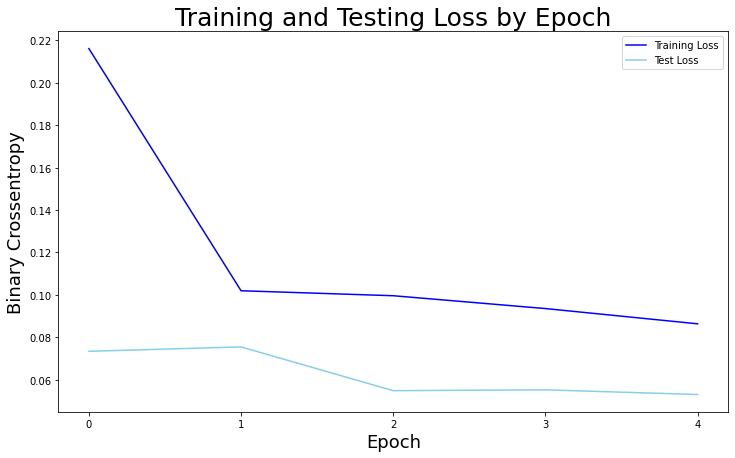

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize = (12, 7))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'], label = 'Test Loss', color = 'skyblue')
# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(np.arange(5), np.arange(5))
plt.legend()
plt.show()
plt.savefig('loss_plot.jpg')

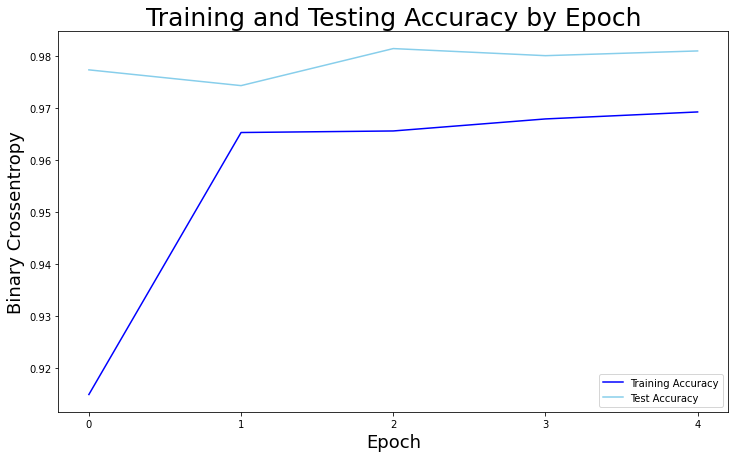

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize = (12, 7))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'blue')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy', color = 'skyblue')
# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(np.arange(5), np.arange(5))
plt.legend(loc='lower right')
plt.show()
plt.savefig('accuracy_plot.jpg')

In [29]:
model.save('./Saved Models/Bert_Suicide_Model')

INFO:tensorflow:Assets written to: Tuning_Bert_Model\assets


INFO:tensorflow:Assets written to: Tuning_Bert_Model\assets


In [84]:
model = tf.keras.models.load_model('./Saved Models/Bert_Suicide_Model')

In [22]:
val_text = pd.read_csv('../Data/ValidationText.csv')
val_text.head(5)

,#,Text,From,Source
0,1,Cut deeper,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
1,2,"Dear mom & dad, I'm sorry for failing you, I'm...",Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
2,3,Confession: My therapist doesn't think my prob...,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
3,4,Depression is not something to be happy about....,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
4,5,I feel really bad tonight...Seriously thinking...,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...


#### Checking the validation of model

In [87]:
model.predict(["yeahhhh i wil go to the gym after 6 months pause"])

array([[0.93298525]], dtype=float32)

In [49]:
model.predict([val_text['Text'][3]])

array([[1.]], dtype=float32)

In [25]:
prediction = model.predict(X_test)

In [4]:
text = ["Today i'm very depressed and sad, lonely"]
model.predict(text)

array([[0.99999917]], dtype=float32)

In [45]:
#Preiction are probabilities so i convert to either 0 or 1
prediction = [1 if x >= 0.5 else 0 for x in prediction]

In [46]:
#Checking the accuracy
accuracy_score(y_test, prediction)

0.980909090909091

In [47]:
#Checking the recall score
recall_score(y_test, prediction)

0.9774707119255032

In [49]:
#Checking the confusion matrix
conf_matrix = confusion_matrix(y_test, prediction)

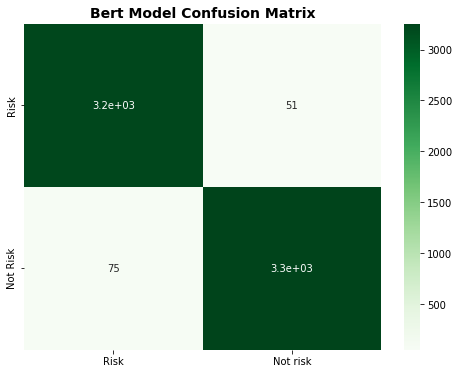

In [187]:
#Plotting the confusion matrix
plt.figure(figsize=(8,6))
plt.title('Bert Model Confusion Matrix', weight = 'bold', fontsize = 14)
fig = sns.heatmap(conf_matrix, cmap = 'Greens', annot = True)
fig.xaxis.set_ticklabels(['Risk', 'Not risk'])
fig.yaxis.set_ticklabels(['Risk', 'Not Risk']);

In [55]:
#Checking the precision score
precision_score(y_test, prediction)

0.9845688350983358

In [56]:
#Checking the f1_score
f1_score(y_test, prediction)

0.9810069339764848

In [59]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3271
           1       0.98      0.98      0.98      3329

    accuracy                           0.98      6600
   macro avg       0.98      0.98      0.98      6600
weighted avg       0.98      0.98      0.98      6600



In [50]:
#Create a funtion to return te risky level based on probability of post
def risk_assessment_prediction(text):
    prob = model.predict([text])
    prob = prob[0][0]
    if prob >= 0.5 and prob < 0.75:
        return f'This Post should be considered Risky (Probability is: {prob})'
    elif prob >= 0.75 and prob < 0.9:
        return f'This Post should be considered High Risky (Probability is: {prob})'
    elif prob >= 0.9:
        return f'Alert!. This Post has a high level of Risk (Probability is: {prob})'
    elif prob < 0.2:
        return  f'This Post should has no signs of Risk (Probability is: {prob})'
    elif prob >= 0.2 and prob < 0.5:
        return f'This Post should not be considered as Risky (Probability is: {prob})'

In [69]:
risk_assessment_prediction("Depression is not something to be happy about. I hate the fact that everything I just said, is only a quarter of what I feel. Some people get excited when they're diagnosed with depression. 'Oh I'm going to tell my friends, maybe I'll get some sympathy .' No you stupid c***. It is the worst thing, that's why, when I was diagnosed with depression. I felt crazy. Because I'm not normal. I'm depressed, and pain lives in me, and I can't escape it. That's the sad thing. No one takes it seriously.")

'Alert!. This Post has a high level of Risk (Probability is: 1.0)'

In [80]:
risk_assessment_prediction('good go away now')

'This Post should not be considered as Risky (Probability is: 0.2038266360759735)'